# IBM Data Science Capstone Project

Please use https://nbviewer.jupyter.org/github/oliverschackmann/Coursera_Capstone/blob/master/CapstoneProject.ipynb to see the rendered maps.

## Introduction/Business Problem

In this project, I will try to contribute to solving a widespread problem in my hometown, Munich. Since two of Germany's best universities (LMU and TUM) are located in Munich, a lot of young people move there. Unfortunately, Munich is known for its high rents. My goal is to help students to find the least expensive districts. Additionally, with the help of machine learning, the areas will be clustered into a few groups based on their venues related to free-time activities. The characteristics of each of these groups will be analyzed, so interested students can make a more informed choice on where to rent an apartment.

---

## Data

To achieve this, we have to use multiple data sources. Rental prices, sorted by districts, can be found in an article by a local newspaper: https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html. With the help of Foursquare, we will gather information about venues in each neighborhood. Using an API request URL, we will receive a json file, which will be used to obtain the name, location, and category of each venue (example below). Furthermore, we will need the coordinates of each district and its shape so that we can create a good looking map. The required geojson file can be downloaded here: https://www.suche-postleitzahl.org/plz-karte-erstellen.

In [1]:
import pandas as pd

# example for data received from Foursquare
pd.DataFrame([["80331","48.135276","11.570982","Ringlers","48.134097","11.568302","Sandwich Place"]],
             columns=["Neighborhood","Neighborhood Latitude","Neighborhood Longitude","Venue","Venue Latitude","Venue Longitude","Venue Category"])

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80331,48.135276,11.570982,Ringlers,48.134097,11.568302,Sandwich Place


---

## Data Acquisition

Importing the required modules

In [2]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

The rental prices sorted by districts can be found on the website of a local newspaper. Since the table has a weird format, it has to be read in 3 parts.

In [3]:
rent0 = pd.read_html("https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html", header=0)[0]
rent1 = pd.read_html("https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html")[1]
rent2 = pd.read_html("https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html")[2]

---

## Data Wrangling

2 little errors in the data have to be corrected.

In [4]:
rent0.iloc[11,1] = 2060
rent1.iloc[17,1] = 1490

In [5]:
rent0.head()

,PLZ,Miete,Trend,Kaufpreis,Trend.1
0,Allach-Untermenzing,NaN,NaN,NaN,NaN
1,80995,1410.0,"1,1%",5000,"6,8%"
2,80997,1325.0,"-1,9%",5430,"12,4%"
3,80999,1305.0,"5,2%",5880,"11,4%"
4,81247,1455.0,"2,5%",6520,"1,4%"


In [6]:
rent1.head()

,0,1,2,3,4
0,Obergiesing-Fasangarten,NaN,NaN,NaN,NaN
1,81539,1570,"0,3%",8420,"-3,9%"
2,81541,1795,"-0,3%",6030,"4,7%"
3,81547,1525,"4,8%",5290,"12,8%"
4,81549,1420,"4,0%",5600,"-0,4%"


In [7]:
rent2.head()

,0,1,2,3,4
0,80804,1845.0,"14,9%",7430,"2,3%"
1,80809,1475.0,"-8,7%",5600,"-2,9%"
2,Schwanthalerhöhe,NaN,NaN,NaN,NaN
3,80335,1955.0,"2,9%",8690,"5,8%"
4,80339,1665.0,"-5,9%",6000,"3,8%"


We only need the columns "PLZ" (German abbreviation for "postal code") and "Miete" (German for "rent").

In [8]:
rent0 = rent0[["PLZ", "Miete"]]
rent1 = rent1[[0, 1]]
rent2 = rent2[[0, 1]]

In [9]:
rent0.columns = ["plz", "rent"]
rent1.columns = ["plz", "rent"]
rent2.columns = ["plz", "rent"]

We only want to have a single dataframe, so we should merge the three dataframes we have.

In [10]:
rent = rent0.append(rent1).append(rent2)

We don't need the names of the boroughs, so let's drop all rows that don't contain a postal code. Duplicate rows, caused by some large districts being in multiple boroughs, can be eliminated too.

In [11]:
rent = rent.dropna()
rent = rent.drop_duplicates(subset="plz")
rent.reset_index(drop=True, inplace=True)

In [12]:
rent.head()

,plz,rent
0,80995,1410
1,80997,1325
2,80999,1305
3,81247,1455
4,81249,1325


For later analysis, the types of the columns have to be changed.

In [13]:
rent = rent.astype({"plz": str, "rent": float})

Because of a different format of the initial data, the rent per $m^2$ has to be scaled by $\frac{1}{100}$.

In [14]:
rent.loc[:,"rent"] = rent.loc[:,"rent"]/100

In [15]:
rent.head()

,plz,rent
0,80995,14.10
1,80997,13.25
2,80999,13.05
3,81247,14.55
4,81249,13.25


---

## Visualization of the Rental Prices

Let's import the geojson file containing the coordinates and shapes of every district in Munich.

In [16]:
munich_geo = r'munich.geojson'

Folium is a great module to create beautiful maps.

In [17]:
munich_map = folium.Map(location=[48.1800048552332, 11.55278981758259], zoom_start=11)

Visualizing the rental prices can be done with a choropleth map. In this context, darker colors indicate more expensive districts.

In [18]:
munich_map.choropleth(
    geo_data=munich_geo,
    data=rent,
    columns=['plz', 'rent'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name='rental price per square metre in EUR'
)

munich_map

Using another geojson file, we can get the coordinates of the center of each district. 

In [19]:
centroids = pd.read_json("munich_centroid.geojson")["features"]
centroids = pd.json_normalize(centroids).loc[:,["geometry.coordinates", "properties.plz"]]

In [20]:
centroids.head()

,geometry.coordinates,properties.plz
0,"[11.570982261637388, 48.135276208093806]",80331
1,"[11.568538825489401, 48.144915664273]",80333
2,"[11.554154530753017, 48.14358629335317]",80335
3,"[11.552986926338054, 48.132913714886676]",80336
4,"[11.558362164549163, 48.12594523821603]",80337


Extracting the latitude and longitude coordinates.

In [21]:
for i in range(74):
    centroids.loc[i, "lat"] = centroids.loc[i, "geometry.coordinates"][1]
    centroids.loc[i, "lon"] = centroids.loc[i, "geometry.coordinates"][0]

In [22]:
centroids.head()

,geometry.coordinates,properties.plz,lat,lon
0,"[11.570982261637388, 48.135276208093806]",80331,48.135276,11.570982
1,"[11.568538825489401, 48.144915664273]",80333,48.144916,11.568539
2,"[11.554154530753017, 48.14358629335317]",80335,48.143586,11.554155
3,"[11.552986926338054, 48.132913714886676]",80336,48.132914,11.552987
4,"[11.558362164549163, 48.12594523821603]",80337,48.125945,11.558362


In [23]:
centroids.drop("geometry.coordinates", axis=1, inplace=True)
centroids.rename(columns={"properties.plz": "plz"}, inplace=True)

In [24]:
centroids.head()

,plz,lat,lon
0,80331,48.135276,11.570982
1,80333,48.144916,11.568539
2,80335,48.143586,11.554155
3,80336,48.132914,11.552987
4,80337,48.125945,11.558362


Let's add markers to the map. Clicking on them reveals the postal code.

In [25]:
for plz, lat, lon in zip(centroids["plz"], centroids["lat"], centroids["lon"]):
    label = '{}'.format(plz)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(munich_map)  
    
munich_map

Adding the locations of two of the biggest campuses of LMU and TUM.

In [26]:
for uni, lat, lon in zip(["LMU", "TUM"], [48.150919,48.269215], [11.579861,11.678462]):
    label = '{}'.format(uni)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label,
        icon=folium.Icon(color='lightgray', icon='university', prefix='fa')).add_to(munich_map)  
    
munich_map

---

# Foursquare

The next step in this analysis is using Foursquare to get the data needed for clustering.

In [27]:
# @hidden_cell
CLIENT_ID = 'IOFQPZ5VP1VMLNFP0TBUKMA2OMEPJXWSK05O2JPU0F0N5B02' # your Foursquare ID
CLIENT_SECRET = 'FUJW5YDVY3KHATWZ131E43GUX3ICZBRKKN1TS1WCVZTJS3DD' # your Foursquare Secret
VERSION = '20200514' # Foursquare API version
radius = 500
LIMIT = 100

Defining a function that extracts the category of the venue.

In [28]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Looking through the returned venue categories, I noticed that some of them are not suitable for clustering because they exist in all districts. These include 'Supermarket', 'Bus Stop', etc. Therefore, I deleted them manually from the list of categories that Foursquare uses to find venues.

In [29]:
fun = ['Afghan Restaurant', 'African Restaurant', 'American Restaurant',
       'Arcade', 'Art Gallery', 'Art Museum',
       'Asian Restaurant', 'Athletics & Sports', 'Austrian Restaurant',
       'BBQ Joint', 'Bagel Shop',
       'Bakery', 'Bar', 'Bavarian Restaurant', 'Beach',
       'Beer Bar', 'Beer Garden', 'Beer Store',
       'Bistro', 'Boat Rental', 'Bookstore',
       'Bosnian Restaurant', 'Botanical Garden', 'Boutique',
       'Bowling Alley', 'Breakfast Spot', 'Brewery', 'Bridge',
       'Burger Joint', 'Burrito Place', 'Butcher',
       'Café', 'Camera Store', 'Canal', 'Candy Store',
       'Cheese Shop', 'Chinese Restaurant', 'Circus',
       'Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'Comedy Club',
       'Comic Shop', 'Community Center', 'Concert Hall',
       'Cretan Restaurant', 'Cupcake Shop', 'Currywurst Joint',
       'Dance Studio', 'Deli / Bodega',
       'Design Studio', 'Dessert Shop', 'Dim Sum Restaurant', 'Diner',
       'Dog Run', 'Doner Restaurant', 'Donut Shop',
       'Dumpling Restaurant', 'Eastern European Restaurant',
       'Ethiopian Restaurant', 'Event Space',
       'Falafel Restaurant', 'Farmers Market', 'Fast Food Restaurant',
       'Field', 'Fish Market', 'Flea Market', 'Food', 'Food & Drink Shop',
       'Food Court', 'Food Truck', 'Fountain', 'French Restaurant',
       'Frozen Yogurt Shop', 'Garden',
       'Gastropub', 'Gay Bar', 'General Entertainment',
       'German Restaurant', 'Gourmet Shop',
       'Greek Restaurant', 'Grilled Meat Restaurant',
       'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Hawaiian Restaurant',
       'Health & Beauty Service', 'Hill', 'Historic Site',
       'History Museum', 'Hockey Arena', 'Hot Dog Joint',
       'Ice Cream Shop', 'Indian Restaurant',
       'Indie Movie Theater',
       'Irish Pub', 'Israeli Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Jazz Club', 'Jewish Restaurant',
       'Juice Bar', 'Kebab Restaurant', 'Korean Restaurant', 'Lake',
       'Lebanese Restaurant',
       'Liquor Store', 'Lounge', 'Manti Place', 'Martial Arts Dojo',
       'Mediterranean Restaurant', 'Memorial Site', "Men's Store",
       'Mexican Restaurant', 'Middle Eastern Restaurant',
       'Modern European Restaurant', 'Modern Greek Restaurant',
       'Monument / Landmark', 'Movie Theater',
       'Museum', 'Music School', 'Music Venue', 'Nightclub',
       'Noodle House',
       'Outdoor Sculpture', 'Palace',
       'Palatine Restaurant', 'Park',
       'Pastry Shop', 'Pedestrian Plaza', 'Performing Arts Venue',
       'Pizza Place', 'Platform',
       'Playground', 'Plaza', 'Poke Place', 'Pool',
       'Portuguese Restaurant', 'Pub', 'Public Art',
       'Ramen Restaurant', 'Recreation Center',
       'Restaurant', 'River', 'Rock Climbing Spot',
       'Roof Deck', 'Salad Place', 'Salon / Barbershop', 'Sandwich Place',
       'Sausage Shop', 'Seafood Restaurant',
       'Shoe Store', 'Shopping Mall', 'Skate Park',
       'Skating Rink', 'Smoke Shop', 'Snack Place', 'Soccer Field',
       'Soup Place', 'Spa', 'Spanish Restaurant', 'Sporting Goods Shop',
       'Sports Bar', 'Sports Club', 'Stadium', 'Steakhouse', 'Strip Club',
       'Surf Spot', 'Sushi Restaurant', 'Taco Place',
       'Tapas Restaurant', 'Taverna', 'Tea Room', 'Tennis Court',
       'Thai Restaurant', 'Theater', 'Tibetan Restaurant',
       'Toy / Game Store', 'Track', 'Trail',
       'Trattoria/Osteria',
       'Turkish Restaurant', 'Vegetarian / Vegan Restaurant',
       'Vietnamese Restaurant', 'Waterfall', 'Wine Bar', 'Wine Shop',
       "Women's Store", 'Xinjiang Restaurant', 'Yoga Studio']

Defining a function that returns a dataframe with all venues in a given radius from the given latitude and longitude coordinates.

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            # only return interesting venues
            if v['venue']['categories'][0]['name'] in fun:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
munich_venues = getNearbyVenues(names=centroids['plz'], latitudes=centroids['lat'], longitudes=centroids['lon'])

80331
80333
80335
80336
80337
80339
80469
80538
80539
80634
80636
80637
80638
80639
80686
80687
80689
80796
80797
80798
80799
80801
80802
80803
80804
80805
80807
80809
80933
80935
80937
80939
80992
80993
80995
80997
80999
81241
81243
81245
81247
81249
81369
81371
81373
81375
81377
81379
81475
81476
81477
81479
81539
81541
81543
81545
81547
81549
81667
81669
81671
81673
81675
81677
81679
81735
81737
81739
81825
81827
81829
81925
81927
81929


In [32]:
print('Foursquare found {} venues.'.format(munich_venues.shape[0]))
munich_venues.head(5)

Foursquare found 1215 venues.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80331,48.135276,11.570982,Ringlers,48.134097,11.568302,Sandwich Place
1,80331,48.135276,11.570982,The High,48.133101,11.572939,Cocktail Bar
2,80331,48.135276,11.570982,TeeGschwendner,48.135398,11.569455,Tea Room
3,80331,48.135276,11.570982,Kleinschmecker,48.134659,11.573565,German Restaurant
4,80331,48.135276,11.570982,landersdorfer & innerhofer - restaurant,48.136237,11.569917,German Restaurant


In [33]:
print('There are {} unique categories.'.format(len(munich_venues['Venue Category'].unique())))

There are 189 unique categories.


We have to use one-hot encoding before we can start to cluster the districts. One hot encoding is a process by which categorical variables are converted into a useful form for the k-means algorithm.

In [34]:
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Neighborhood'] = munich_venues['Neighborhood'] 

# move neighborhood column to the first column
munich_onehot = munich_onehot[ ['Neighborhood'] + [ col for col in munich_onehot.columns if col != 'Neighborhood' ] ]

munich_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio
0,80331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group the dataframe by 'Neighborhood' to see which types of venues are in each district.

In [35]:
munich_grouped = munich_onehot.groupby('Neighborhood').mean().reset_index()

In [36]:
munich_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio
0,80331,0.023810,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.011905,0.011905,0.0,0.000000,0.011905,0.011905,0.000000,0.0
1,80333,0.000000,0.000000,0.0,0.0,0.017544,0.052632,0.017544,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,80335,0.041667,0.000000,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.000000,...,0.041667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,80336,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.062500,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.062500,0.000000,0.000000,0.0
4,80337,0.000000,0.033333,0.0,0.0,0.016667,0.000000,0.000000,0.0,0.016667,...,0.000000,0.0,0.000000,0.033333,0.0,0.016667,0.000000,0.000000,0.016667,0.0


Defining a function that uses this dataframe to return the most common venues of each district.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe displaying the top 10 venues for each neighborhood.

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = munich_grouped['Neighborhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80331,Café,German Restaurant,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cocktail Bar,Clothing Store,Tea Room,Museum
1,80333,Café,History Museum,Plaza,Nightclub,Bar,Art Museum,Restaurant,Fountain,Burger Joint,Museum
2,80335,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Afghan Restaurant,Bavarian Restaurant,Diner,Doner Restaurant,Restaurant,Salad Place,Circus
3,80336,Plaza,BBQ Joint,Middle Eastern Restaurant,Café,Movie Theater,Chinese Restaurant,Cocktail Bar,German Restaurant,Eastern European Restaurant,Bakery
4,80337,Italian Restaurant,Café,Bakery,Burger Joint,Restaurant,Nightclub,Seafood Restaurant,Plaza,Vietnamese Restaurant,German Restaurant


---

## Clustering the Neighborhoods

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
munich_grouped_clustering = munich_grouped.drop('Neighborhood', 1)

In [41]:
munich_grouped_clustering.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio
0,0.023810,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,...,0.000000,0.0,0.011905,0.011905,0.0,0.000000,0.011905,0.011905,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.017544,0.052632,0.017544,0.0,0.000000,0.0000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.041667,0.000000,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.000000,0.0000,...,0.041667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.062500,0.0,0.000000,0.0625,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.062500,0.000000,0.000000,0.0
4,0.000000,0.033333,0.0,0.0,0.016667,0.000000,0.000000,0.0,0.016667,0.0000,...,0.000000,0.0,0.000000,0.033333,0.0,0.016667,0.000000,0.000000,0.016667,0.0


Running the silhouette_score algorithm multiple times shows us that the optimal number of clusters is 5.

[0.21353637 0.20908388 0.25124452 0.25904949 0.23901356 0.24902457
 0.24871708 0.12311714 0.16682291]
[0.21353637 0.20908388 0.22071097 0.23273818 0.2348365  0.24360852
 0.22979333 0.12574164 0.09534069]
[0.21353637 0.20908388 0.23778199 0.26255218 0.26256478 0.24438661
 0.23820371 0.0942495  0.09953042]
[0.21353637 0.20908388 0.25124452 0.26640083 0.26256478 0.2475655
 0.25038355 0.10157853 0.10607691]
[0.21353637 0.20908388 0.21896563 0.25818588 0.2345728  0.2343444
 0.24103375 0.13662328 0.11550591]
[0.23230074 0.20908388 0.25124452 0.25904949 0.26303525 0.24068716
 0.1869277  0.12229726 0.14299718]
[0.21353637 0.20908388 0.21600363 0.26640083 0.26256478 0.24427417
 0.25038355 0.16341534 0.17912811]
[0.21353637 0.24203008 0.25124452 0.23106324 0.26303525 0.24585607
 0.24784056 0.10116124 0.12004765]
[0.21353637 0.20908388 0.21866963 0.25904949 0.24800223 0.2241489
 0.22032782 0.1312052  0.12711523]
[0.21353637 0.20908388 0.25786385 0.25632308 0.26256478 0.25056412
 0.24351164 0.2122

Text(0, 0.5, 'silhouette score')

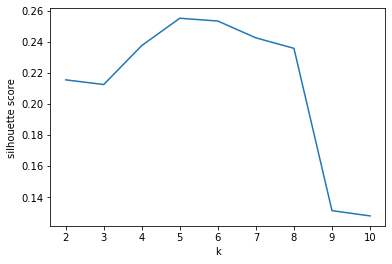

In [58]:
y = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
kmax = 10

for i in range(10):
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    sil = np.array([])
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k, n_init = 100).fit(munich_grouped_clustering)
        labels = kmeans.labels_
        sil = np.insert(sil, k-2, silhouette_score(munich_grouped_clustering, labels, metric = 'euclidean'))
    print(sil)
    y+= sil
y = y/10
x = range(2, kmax+1)
plt.plot(x,y)
plt.xlabel("k")
plt.ylabel("silhouette score")

In [43]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=1000).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 4, 1, 0, 3, 1, 0, 0, 4, 3, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 2, 0, 0, 3])

Adding clustering labels.

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

In [45]:
neighborhoods_venues_sorted.head()

,Cluster Label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,80331,Café,German Restaurant,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cocktail Bar,Clothing Store,Tea Room,Museum
1,0,80333,Café,History Museum,Plaza,Nightclub,Bar,Art Museum,Restaurant,Fountain,Burger Joint,Museum
2,0,80335,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Afghan Restaurant,Bavarian Restaurant,Diner,Doner Restaurant,Restaurant,Salad Place,Circus
3,0,80336,Plaza,BBQ Joint,Middle Eastern Restaurant,Café,Movie Theater,Chinese Restaurant,Cocktail Bar,German Restaurant,Eastern European Restaurant,Bakery
4,0,80337,Italian Restaurant,Café,Bakery,Burger Joint,Restaurant,Nightclub,Seafood Restaurant,Plaza,Vietnamese Restaurant,German Restaurant


We add the latitude and longitude coordinates for each neighborhood by joining two dataframes.

In [46]:
munich_merged = centroids.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='plz')

Because Foursquare didn't find venues for all districts, we have to drop the columns with NaN values.

In [47]:
munich_merged.dropna(inplace=True)
munich_merged.reset_index(drop=True, inplace=True)
munich_merged["Cluster Label"] = munich_merged["Cluster Label"].astype(int)
munich_merged.head()

,plz,lat,lon,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80331,48.135276,11.570982,0,Café,German Restaurant,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cocktail Bar,Clothing Store,Tea Room,Museum
1,80333,48.144916,11.568539,0,Café,History Museum,Plaza,Nightclub,Bar,Art Museum,Restaurant,Fountain,Burger Joint,Museum
2,80335,48.143586,11.554155,0,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Afghan Restaurant,Bavarian Restaurant,Diner,Doner Restaurant,Restaurant,Salad Place,Circus
3,80336,48.132914,11.552987,0,Plaza,BBQ Joint,Middle Eastern Restaurant,Café,Movie Theater,Chinese Restaurant,Cocktail Bar,German Restaurant,Eastern European Restaurant,Bakery
4,80337,48.125945,11.558362,0,Italian Restaurant,Café,Bakery,Burger Joint,Restaurant,Nightclub,Seafood Restaurant,Plaza,Vietnamese Restaurant,German Restaurant


---

## Examining the Results

Let's look at the most common venues in each cluster.

### Cluster 0

In [48]:
top5c0 = munich_merged.loc[munich_merged['Cluster Label'] == 0, munich_merged.columns[[4,5,6,7,8]]].reset_index(drop=True)
munich_merged.loc[munich_merged['Cluster Label'] == 0, munich_merged.columns[[0,3,4,5,6,7,8]]].head()

,plz,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,80331,0,Café,German Restaurant,Coffee Shop,Plaza,Bavarian Restaurant
1,80333,0,Café,History Museum,Plaza,Nightclub,Bar
2,80335,0,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Afghan Restaurant,Bavarian Restaurant
3,80336,0,Plaza,BBQ Joint,Middle Eastern Restaurant,Café,Movie Theater
4,80337,0,Italian Restaurant,Café,Bakery,Burger Joint,Restaurant


We can see that  __'Italian Restaurant'__, __'Café'__, and __'German Restaurant'__ are the most frequent venues in the top 5 of cluster 0.

In [49]:
fcount0 = pd.DataFrame(columns=["name","count"])
for f in fun:
    for r in range(len(top5c0.index)):
        for i in range(5):
            if f == top5c0.iloc[r,i]:
                fcount0 = fcount0.append(pd.DataFrame([[f,1]], columns=["name","count"]))
fcount0.groupby(by="name").sum().sort_values(by="count", ascending=False).head()

,count
name,
Italian Restaurant,27
Café,26
German Restaurant,14
Bakery,12
Park,12


### Cluster 1

In [50]:
top5c1 = munich_merged.loc[munich_merged['Cluster Label'] == 1, munich_merged.columns[[4,5,6,7,8]]].reset_index(drop=True)
munich_merged.loc[munich_merged['Cluster Label'] == 1, munich_merged.columns[[0,3,4,5,6,7,8]]].head()

,plz,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,80686,1,Dog Run,Beer Garden,Yoga Studio,Event Space,Food & Drink Shop
30,80937,1,Beer Garden,Yoga Studio,Food Truck,Food & Drink Shop,Food
33,80993,1,Bakery,Beer Garden,Ethiopian Restaurant,Food & Drink Shop,Food


__'Beer Garden'__, and __'Food & Drink Shop'__ are the most frequent venues in the top 5 of cluster 1.

In [51]:
fcount1 = pd.DataFrame(columns=["name","count"])
for f in fun:
    for r in range(len(top5c1.index)):
        for i in range(5):
            if f == top5c1.iloc[r,i]:
                fcount1 = fcount1.append(pd.DataFrame([[f,1]], columns=["name","count"]))
fcount1.groupby(by="name").sum().sort_values(by="count", ascending=False).head()

,count
name,
Beer Garden,3
Food & Drink Shop,3
Food,2
Yoga Studio,2
Bakery,1


### Cluster 2

There is just one district in cluster 2 and the most common venue is __'Health & Beauty Service'__.

In [52]:
top5c2 = munich_merged.loc[munich_merged['Cluster Label'] == 2, munich_merged.columns[[4,5,6,7,8]]].reset_index(drop=True)
munich_merged.loc[munich_merged['Cluster Label'] == 2, munich_merged.columns[[0,3,4,5,6,7,8]]].head()

,plz,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
67,81827,2,Health & Beauty Service,Yoga Studio,Eastern European Restaurant,Food,Flea Market


### Cluster 3

In [53]:
top5c3 = munich_merged.loc[munich_merged['Cluster Label'] == 3, munich_merged.columns[[4,5,6,7,8]]].reset_index(drop=True)
munich_merged.loc[munich_merged['Cluster Label'] == 3, munich_merged.columns[[0,3,4,5,6,7,8]]].head()

,plz,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,80687,3,Bakery,Sporting Goods Shop,Coffee Shop,Skate Park,Chinese Restaurant
16,80689,3,Bakery,Food Truck,Food & Drink Shop,Food,Flea Market
28,80933,3,Plaza,Bakery,Eastern European Restaurant,Food,Flea Market
32,80992,3,Bakery,Shoe Store,Asian Restaurant,Food,Flea Market
37,81243,3,Bakery,Asian Restaurant,Smoke Shop,Park,Eastern European Restaurant


__'Bakery'__ and __'Food'__ are the most frequent venues in the top 5 of cluster 3.

In [54]:
fcount3 = pd.DataFrame(columns=["name","count"])
for f in fun:
    for r in range(len(top5c3.index)):
        for i in range(5):
            if f == top5c3.iloc[r,i]:
                fcount3 = fcount3.append(pd.DataFrame([[f,1]], columns=["name","count"]))
fcount3.groupby(by="name").sum().sort_values(by="count", ascending=False).head()

,count
name,
Bakery,9
Food,6
Flea Market,4
Eastern European Restaurant,4
Park,3


### Cluster 4

In [55]:
top5c4 = munich_merged.loc[munich_merged['Cluster Label'] == 4, munich_merged.columns[[4,5,6,7,8]]].reset_index(drop=True)
munich_merged.loc[munich_merged['Cluster Label'] == 4, munich_merged.columns[[0,3,4,5,6,7,8]]].head()

,plz,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,80935,4,Soccer Field,Tennis Court,German Restaurant,Yoga Studio,Ethiopian Restaurant
36,81241,4,German Restaurant,Yoga Studio,Food Court,Food,Flea Market
65,81739,4,Soccer Field,Yoga Studio,Cupcake Shop,Food,Flea Market


__'Yoga Studio'__ is the most frequent venue in the top 5 of cluster 4.

In [56]:
fcount4 = pd.DataFrame(columns=["name","count"])
for f in fun:
    for r in range(len(top5c4.index)):
        for i in range(5):
            if f == top5c4.iloc[r,i]:
                fcount4 = fcount4.append(pd.DataFrame([[f,1]], columns=["name","count"]))
fcount4.groupby(by="name").sum().sort_values(by="count", ascending=False).head()

,count
name,
Yoga Studio,3
Flea Market,2
Food,2
German Restaurant,2
Soccer Field,2


---

## Final Map

Clicking on the dots reveal the postal code, cluster label and the most common type of venues.

In [59]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = ["aqua", "lime", "red", "yellow", "blue"]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
cat = ["Restaurants", "Beer Gardens", "Health & Beauty", "Bakeries", "Yoga Studios"]
for lat, lon, plz, cluster in zip(munich_merged['lat'], munich_merged['lon'], munich_merged['plz'], munich_merged['Cluster Label']):
    label = folium.Popup(str(plz) + ' Cluster ' + str(cluster) + ': ' + cat[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(munich_map)
       
munich_map

---

## Summary

This is what we have done:
- Create a dataframe including the rental prices sorted by postal codes
- Generate a choropleth map with the help of a geojson file based on the rental prices
- Add markers for every district and the two biggest campuses
- Extract interesting venues with Foursquare
- List the ten most common venues for each district
- Cluster the districts with the k-means algorithm, having calculated the optimal k
- Examine all clusters and display them on the map 

---

## Discussion of the Results

Since this project is rather short, it is apparent that its recommendations have to be taken with a grain of salt. There are a few aspects that have to be kept in mind: Firstly, there could be some bargains in a region with high average rental prices. Secondly, low rental prices most likely are low for good reasons, so look out for them. Consequently, I don't recommend choosing a district just based on its average rental price. There are also a few problems using Foursquare (which was a requirement by IBM for this Capstone Project). We can't tell to which extent Foursquare's database provides an accurate representation of each district. Clearly, not every venue can be listed, but not finding even a single venue for three districts is a rather unfortunate result. Additionally, we considered only the relative frequency but not the absolute numbers of venues in each area. This may lead to wrong conclusions, especially for districts where Foursquare found just a few results.

---

## Conclusion

I hope that this map can be a good starting point for everybody considering moving to Munich.
Thank you for reading!